In [1]:
import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from scipy import stats

from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian2DKernel

from tqdm import tqdm

In [2]:
path = r'/data2/goesaert/'
fname = 'Abell_85_Linpol_Freqmean'
hdu = fits.open(get_pkg_data_filename(path+fname+'.fits'))[0]
header = hdu.header
data = hdu.data

In [3]:
mask_sources = np.load('testmask.npy')
data_masked = ma.masked_array(data, mask = mask_sources)

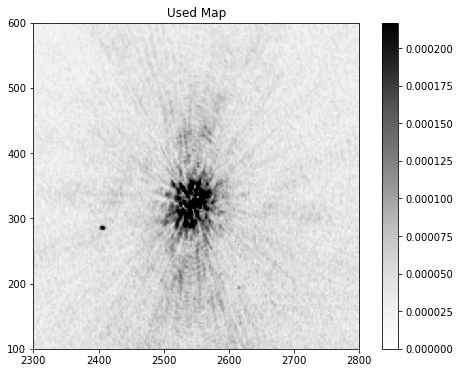

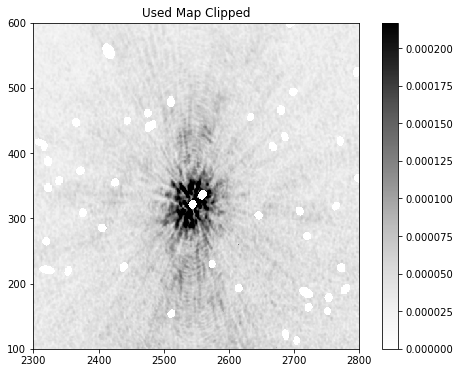

In [74]:
plt.figure(figsize=(8,6))
plt.title('Used Map')
plt.imshow(data, vmin=0, vmax=0.02*np.max(data), cmap='Greys', origin='lower', interpolation='nearest')
plt.colorbar()
plt.xlim(2300, 2800)
plt.ylim(100, 600)
plt.show()

plt.figure(figsize=(8,6))
plt.title('Used Map Clipped')
plt.imshow(data_masked_nan, cmap='Greys', origin='lower', vmin=0, vmax=0.02*np.max(data), interpolation='nearest')
plt.colorbar()
plt.xlim(2300, 2800)
plt.ylim(100, 600)
plt.show()

In [33]:
data_masked_nan = np.where(data_masked.mask,np.nan,data_masked)
kernel = Gaussian2DKernel(x_stddev=10, x_size=51, y_size=51)
mean = convolve(data_masked_nan, kernel, boundary='extend')
#mean2 = convolve_fft(data_masked_nan, kernel)
rms = np.sqrt(convolve(data_masked_nan**2, kernel, boundary='extend'))
#rms2 = np.sqrt(convolve_fft(data_masked_nan**2, kernel))
std = np.sqrt(convolve((data_masked_nan-mean)**2, kernel, boundary='extend'))

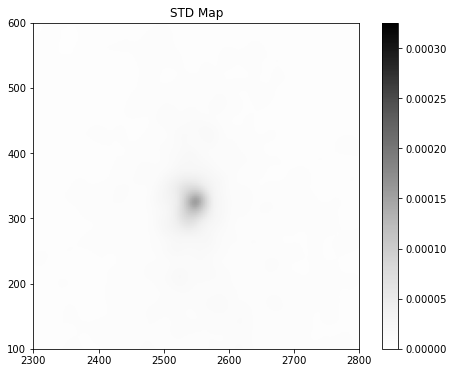

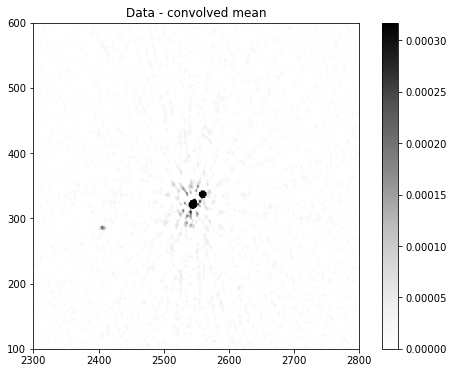

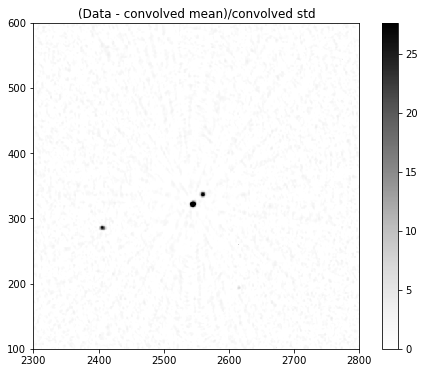

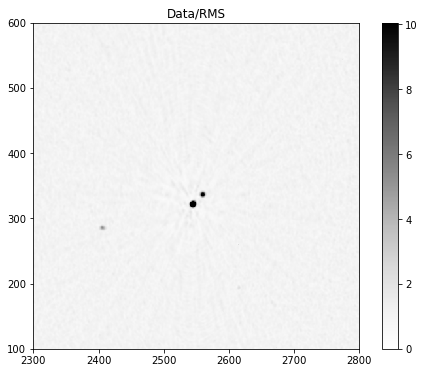

In [79]:
plt.figure(figsize=(8,6))
plt.title('STD Map')
plt.imshow(std, vmin=0, vmax=0.03*np.max(data), cmap='Greys', origin='lower', interpolation='nearest')
plt.colorbar()
plt.xlim(2300, 2800)
plt.ylim(100, 600)
plt.show()

plt.figure(figsize=(8,6))
plt.title('Data - convolved mean')
plt.imshow(data-mean, vmin=0, vmax=0.03*np.max(data-mean), cmap='Greys', origin='lower', interpolation='nearest')
plt.colorbar()
plt.xlim(2300, 2800)
plt.ylim(100, 600)
plt.show()

plt.figure(figsize=(8,6))
plt.title('(Data - convolved mean)/convolved std')
plt.imshow((data-mean)/std, vmin=0, vmax=0.2*np.max((data-mean)/std), cmap='Greys', origin='lower', interpolation='nearest')
plt.colorbar()
plt.xlim(2300, 2800)
plt.ylim(100, 600)
plt.show()

plt.figure(figsize=(8,6))
plt.title('Data/RMS')
plt.imshow(data/rms, vmin=0, vmax=0.2*np.max(data/rms), cmap='Greys', origin='lower', interpolation='nearest')
plt.colorbar()
plt.xlim(2300, 2800)
plt.ylim(100, 600)
plt.show()

In [9]:
directory = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/'
Sourcefind = data/rms
Sourcefind2 = data-mean
Fits_RMS = fits.PrimaryHDU(rms)
Fits_Mean = fits.PrimaryHDU(mean)
Fits_Sourcefind = fits.PrimaryHDU(data/rms) #Deze is de beste! data/rms>2 geeft super goede selectie!
Fits_Sourcefind2 = fits.PrimaryHDU(data-mean)
Fits_RMS.writeto(directory+'Abell_85_Fits_RMS.fits', overwrite=True)
Fits_Mean.writeto(directory+'Abell_85_Fits_Mean.fits', overwrite=True)
Fits_Sourcefind.writeto(directory+'Abell_85_Fits_Sourcefind.fits', overwrite=True)
Fits_Sourcefind2.writeto(directory+'Abell_85_Fits_Sourcefind2.fits', overwrite=True)

In [12]:
percentiles = np.percentile(Sourcefind2, [25, 50, 75])
median_tot = percentiles[1]
rms_tot = (percentiles[2] - percentiles[0])/(stats.norm.ppf(0.75) - stats.norm.ppf(0.25))
print(median_tot, rms_tot)
print(10*rms_tot)

-1.2532382243080065e-07 3.4654162505158814e-06
3.4654162505158815e-05


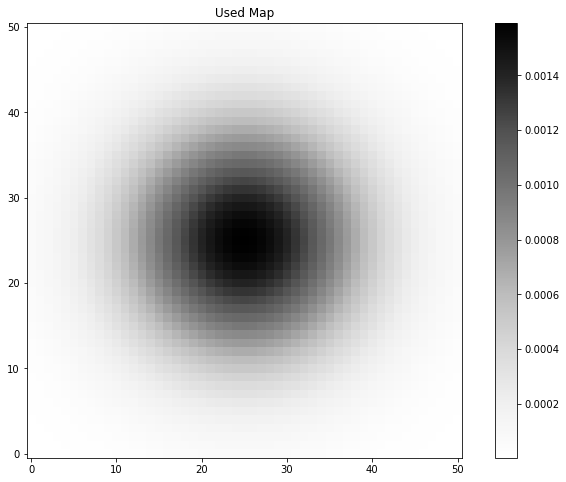

In [13]:
plt.figure(figsize=(12,8))
plt.title('Used Map')
plt.imshow(kernel, cmap='Greys', origin='lower', interpolation='nearest')
plt.colorbar()
plt.show()